In [2]:
#import des principaux packages

%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.style.use('ggplot')
from IPython.display import display
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
#import du .csv dans un dataframe

path = "atp_data.csv"
df = pd.read_csv(path, sep =",",index_col = 0)

#Ce fichier nous servira principalement à extraire les cotes propres

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44708 entries, 1 to 18
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Location    44708 non-null  object 
 1   Tournament  44708 non-null  object 
 2   Date        44708 non-null  object 
 3   Series      44708 non-null  object 
 4   Court       44708 non-null  object 
 5   Surface     44708 non-null  object 
 6   Round       44708 non-null  object 
 7   Best of     44708 non-null  int64  
 8   Winner      44708 non-null  object 
 9   Loser       44708 non-null  object 
 10  WRank       44708 non-null  int64  
 11  LRank       44708 non-null  int64  
 12  Wsets       44521 non-null  float64
 13  Lsets       44521 non-null  float64
 14  Comment     44708 non-null  object 
 15  PSW         32743 non-null  float64
 16  PSL         32743 non-null  float64
 17  B365W       39037 non-null  float64
 18  B365L       39057 non-null  float64
 19  elo_winner  44708 non-null  

In [5]:
df.PSW.isna().sum()/df.shape[0]

0.26762548089827326

In [6]:
df.B365W.isna().sum()/df.shape[0]

0.12684530732754765

Il y a des données manquantes principalement sur les cotes Pinnacles et B365 quelques unes aussi sur WSets et LSets

In [7]:
#remplacement des Nan Wsets et Lsets par leur modalité les plus fréquentes

nb_sets_5_W = df.loc[df["Best of"] == 5]["Wsets"].mode()[0]
nb_sets_3_W = df.loc[df["Best of"] == 3]["Wsets"].mode()[0]

nb_sets_5_L = df.loc[df["Best of"] == 5]["Lsets"].mode()[0]
nb_sets_3_L = df.loc[df["Best of"] == 3]["Lsets"].mode()[0]

In [8]:
df.loc[(df["Best of"] == 5) & (df["Wsets"] != 3), 'Wsets'] = nb_sets_5_W
df.loc[(df["Best of"] == 3) & (df["Wsets"] != 3), 'Wsets'] = nb_sets_3_W

df.loc[(df["Best of"] == 5) & (df["Lsets"] != 0) & (df["Lsets"] != 1) & (df["Lsets"] != 2), 'Lsets'] = nb_sets_5_L
df.loc[(df["Best of"] == 3) & (df["Lsets"] != 0) & (df["Lsets"] != 1), 'Lsets'] = nb_sets_3_L


In [9]:
test = df.isna()
test = test.reset_index()
df = df.reset_index()

In [10]:
#Cas ou l'on remplace une cote manquante de Pinnacle par celle présente de B365

index1 = list(test.loc[(test['PSW'] == True) & (test["B365W"] == False)].index)
index2 = list(test.loc[(test['PSL'] == True) & (test["B365L"] == False)].index)

df["PSW"].loc[index1] = df["B365W"].loc[index1]
df["PSL"].loc[index2] = df["B365L"].loc[index2]

D:\Olia\Documents\Papa\Conda\envs\jupyter\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
#On traite le cas ou il y a une cote PSL et Pas de cote PSW en fait ce cas n'existe pas
index1 = list(test.loc[(test['PSW'] == True) & (test["PSL"] == False)].index)

#On traite le cas ou il y a une cote B365L et Pas de cote B365W en fait ce cas n'existe pas
index2 = list(test.loc[(test['B365W'] == True) & (test["B365L"] == False)].index)

#On extrapole la cote manquante avec la relation 1/Xwinner + 1/Xloser = 1
df["B365W"].loc[index2] = df["B365L"].loc[index2] / (df["B365L"].loc[index2] - 1)


In [12]:
#On traite le cas ou il n'y a aucune cote, dans ce cas la, on utilise la proba_elo
#qui est la probabilité que le vainqueur gagne (avant match) donc la cote Winner
#On interpole les cotes Loser avec la formule ==> 1/Xwinner + 1/Xloser = 1
#On se cantonne aux proba_elo comprises entre 0.2 et 0.8 pour ne pas générer trop de cotes extrèmes artificiellement

index1 = list(test.loc[(test['PSW'] == True)].index)
index1 = list(df.loc[index1].loc[(df["proba_elo"] >= 0.2) & ((df["proba_elo"] <= 0.8) )].index)

df["PSW"].loc[index1] = 1 / df.proba_elo.loc[index1]
df["PSL"].loc[index1] = df["PSW"].loc[index1] / (df["PSW"].loc[index1] - 1)

df["B365W"].loc[index1] = 1 / df.proba_elo.loc[index1]
df["B365L"].loc[index1] = df["B365W"].loc[index1] / (df["B365W"].loc[index1] - 1)   

In [13]:
#On se débarasse des dernières lignes sans cote elles correspondent aux valeurs de proba_elo
#inférieures à 0.2 et supérieures à 0.8

df = df.dropna(axis=0, how='any')

On vérifie qu'il n'y a plus de NaN:

In [14]:
print("le dataframe contient", df.isna().sum().sum(), "Nan")

le dataframe contient 0 Nan


On vérifie que notre traitement des data n'a pas généré de valeurs aberrantes

In [15]:
#Verification des premières modifications sur Wsets et LSets:

print(df.Wsets.value_counts())
print(df.Lsets.value_counts())

2.0    35825
3.0     8280
Name: Wsets, dtype: int64
0.0    27756
1.0    14811
2.0     1538
Name: Lsets, dtype: int64


Il n'y a pas de Valeurs aberrantes générées sur WSets et LSets

Vérification pour les cotes :

In [16]:
#Nous allons vérifier si le traitement des datas manquantes a généré des valeurs aberrantes
path = "..\\Data\\atp_data.csv"
df_verif = pd.read_csv(path, sep =",",index_col = 0)

#On drop tous les Nan de la base
df_verif = df_verif.dropna(axis = 0, how = "any")

In [17]:
                    #Vérification pour Pinnacle
#=======================================================================
print("cote Pinnacle Loser Min identiques avant et après traitement \n", 
      df.PSL.describe()[3] == df_verif.PSL.describe()[3])

print("cote Pinnacle Loser Max identiques avant et après traitement \n", 
      df.PSL.describe()[7] == df_verif.PSL.describe()[7])

print("cote Pinnacle Loser Min identiques avant et après traitement \n", 
      df.PSW.describe()[3] == df_verif.PSW.describe()[3])

print("cote Pinnacle Loser Max identiques avant et après traitement \n", 
      df.PSW.describe()[7] == df_verif.PSW.describe()[7])
#========================================================================

                    #Vérification pour B365
#=======================================================================
print("cote B365 Loser Min identiques avant et après traitement \n", 
      df.B365L.describe()[3] == df_verif.B365L.describe()[3])

print("cote B365 Loser Max identiques avant et après traitement \n", 
      df.B365L.describe()[7] == df_verif.B365L.describe()[7])

print("cote B365 Loser Min identiques avant et après traitement \n", 
      df.B365W.describe()[3] == df_verif.B365W.describe()[3])

print("cote B365 Loser Max identiques avant et après traitement \n", 
      df.B365W.describe()[7] == df_verif.B365W.describe()[7])
#========================================================================

cote Pinnacle Loser Min identiques avant et après traitement 
 True
cote Pinnacle Loser Max identiques avant et après traitement 
 True
cote Pinnacle Loser Min identiques avant et après traitement 
 True
cote Pinnacle Loser Max identiques avant et après traitement 
 True
cote B365 Loser Min identiques avant et après traitement 
 True
cote B365 Loser Max identiques avant et après traitement 
 True
cote B365 Loser Min identiques avant et après traitement 
 True
cote B365 Loser Max identiques avant et après traitement 
 True


In [18]:
df.PSW.describe()

count    44105.000000
mean         1.942329
std          1.238314
min          1.000000
25%          1.316273
50%          1.620000
75%          2.160000
max         46.000000
Name: PSW, dtype: float64

In [19]:
df.PSL.describe()


count    44105.000000
mean         3.857635
std          5.087951
min          1.010000
25%          1.806000
50%          2.510000
75%          3.850000
max        121.000000
Name: PSL, dtype: float64

In [20]:
df.B365W.describe()

count    44105.000000
mean         1.866542
std          1.060013
min          1.000000
25%          1.280000
50%          1.570000
75%          2.100000
max         29.000000
Name: B365W, dtype: float64

In [21]:
df.B365L.describe()

count    44105.000000
mean         3.396950
std          3.310709
min          1.002000
25%          1.723615
50%          2.421693
75%          3.750000
max        101.000000
Name: B365L, dtype: float64

Nous avons des cotes max Winner/loser de 29/101 pour B3654 et 46/121 pour Pinnacle

Cela correspond aux cotes max avt les modifications

Nos modifications n'ont pas générées de valeurs extrême

Notons que les distributions semblent comporter des valeurs extrèmes,
ce qui est normale au tennis car les surprises sont très rares sur un énorme
écart de niveau, contrairement au football.

On a désormais une base complète et nous avons fait la vérification sur nos modifications de Nan.
Voyons désormais si les autres features contiennent des valeurs aberrantes :

In [22]:
numeric = df.select_dtypes(include=['int', 'float'])
numeric.describe()

,ATP,Best of,WRank,LRank,Wsets,Lsets,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
count,44105.000000,44105.000000,44105.000000,44105.000000,44105.000000,44105.000000,44105.000000,44105.000000,44105.000000,44105.000000,44105.000000,44105.000000,44105.000000
mean,32.808094,3.374878,58.849609,92.647591,2.187734,0.405555,1.942329,3.857635,1.866542,3.396950,1684.919086,1609.845174,0.585322
std,18.174112,0.780536,74.324096,122.604814,0.390504,0.557521,1.238314,5.087951,1.060013,3.310709,179.529714,137.992795,0.198344
min,1.000000,3.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1.010000,1.000000,1.002000,1318.945207,1327.551888,0.008899
25%,19.000000,3.000000,17.000000,35.000000,2.000000,0.000000,1.316273,1.806000,1.280000,1.723615,1549.365125,1502.769686,0.447849
50%,32.000000,3.000000,41.000000,65.000000,2.000000,0.000000,1.620000,2.510000,1.570000,2.421693,1653.375418,1582.027444,0.588724
75%,49.000000,3.000000,77.000000,105.000000,2.000000,1.000000,2.160000,3.850000,2.100000,3.750000,1781.501807,1685.381101,0.736251
max,69.000000,5.000000,2000.000000,2000.000000,3.000000,2.000000,46.000000,121.000000,29.000000,101.000000,2392.408923,2392.595567,0.995601


Les valeurs numeriques ne semblent pas contenir de valeurs aberrantes si ce n'est le calssement ATP à 0. A quoi correspond-il, peut être à un joueur non classé à l'ATP, nous utiliserons de toutes facons, le classement ATP fournit par la seconde base.

<Figure size 720x504 with 0 Axes>

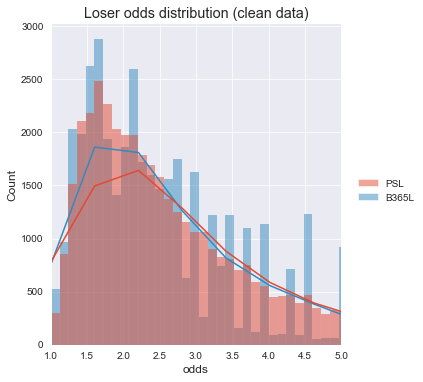

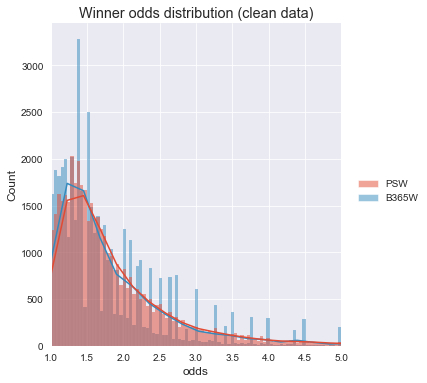

In [24]:
#affichage de la distribution des cotes Loser et Winner de Pinnacle et B365
fig = plt.figure(figsize=(10, 7))

ax1 = sns.displot(df[['PSL', "B365L"]],bins = 1000, kde = True)
plt.xlim(1,5)
plt.title("Loser odds distribution (clean data)")
plt.xlabel("odds")
plt.show();

ax2 = sns.displot(df[['PSW', "B365W"]],bins = 1000, kde = True)
plt.xlim(1,5)
plt.title("Winner odds distribution (clean data)")
plt.xlabel("odds")
plt.show();

les pics dans la distributions B365W et B365L proviennent peut être du traitement des data, ou alors il s 'agit d'une spécificité de B365.
En moyenne sur l'interval 1, 5 les distributions se comportent de manières similaires bien que B365 semble coter légèrement plus de perdant sur l'interval 1, 5

In [25]:
#Nous allons vérifier si la distribution des cotes B365W est similaire avt le traitement des data
path = "..\\Data\\atp_data.csv"
df_verif = pd.read_csv(path, sep =",",index_col = 0)

In [26]:
#On drop toutes les valeurs avec des NaN
df_verif = df_verif.dropna(axis = 0, how = "any")

<Figure size 720x504 with 0 Axes>

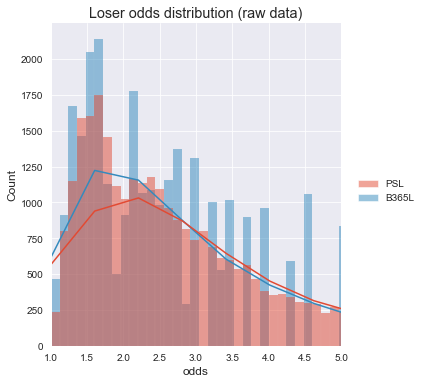

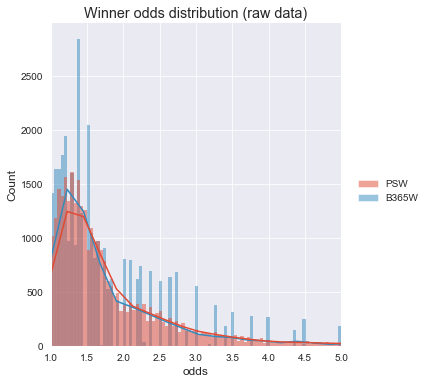

In [27]:
#affichage de la distribution des cotes Loser et Winner de Pinnacle et B365 sans retraitement des données :
fig = plt.figure(figsize=(10, 7))

ax1 = sns.displot(df_verif[['PSL', "B365L"]],bins = 1000, kde = True)
plt.xlim(1,5)
plt.title("Loser odds distribution (raw data)")
plt.xlabel("odds")
plt.show();

ax2 = sns.displot(df_verif[['PSW', "B365W"]],bins = 1000, kde = True)
plt.xlim(1,5)
plt.title("Winner odds distribution (raw data)")
plt.xlabel("odds")
plt.show();

Sans traitement préalable des data B365 il semblerait que les cotes B365 soient réparties de manières très discontinues 
alors que les cotes Pinnacle semblent avoir une répartition continues.

In [28]:
print(len(np.unique(df_verif["B365W"])), "valeurs uniques dans B365W")
print(len(np.unique(df_verif["PSW"])), "valeurs uniques dans PSW")

131 valeurs uniques dans B365W
1173 valeurs uniques dans PSW


la distribution de B365W avt traitement présente en effet environ 10 fois moins de valeur unique que celle de Pinnacle

Etudions la distribution des rapports de cotes entre les deux bookmakers.

In [25]:
#On rajoute deux colonnes delta cote : (Pinnacle / B365) Looser et Winner
df['DeltaW'] = df["PSW"] / df["B365W"]
df['DeltaL'] = df["PSL"] / df["B365L"]

<Figure size 720x504 with 0 Axes>

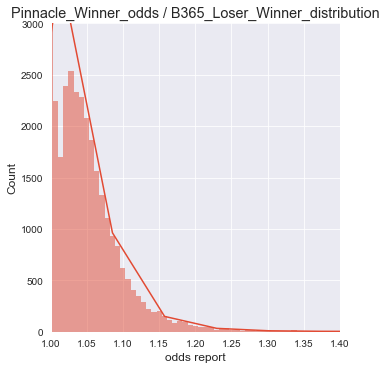

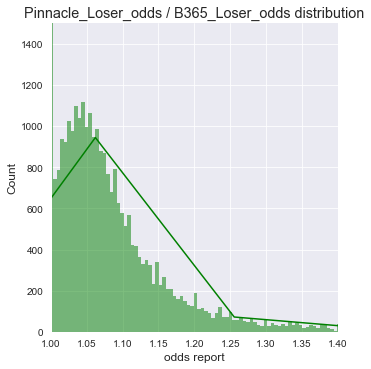

In [26]:
#affichage de la distribution du rapport des cotes Loser et Winner de Pinnacle et B365 sans retraitement des données :
fig = plt.figure(figsize=(10, 7))

sns.displot(df["DeltaW"], bins = 2000, kde = True)
plt.xlim(1,1.4)
plt.ylim(0,3000)
plt.title("Pinnacle_Winner_odds / B365_Loser_Winner_distribution")
plt.xlabel("odds report")
plt.show();

sns.displot(df["DeltaL"], kde = True, color = "green")
plt.xlim(1,1.4)
plt.ylim(0,1500)
plt.title("Pinnacle_Loser_odds / B365_Loser_odds distribution")
plt.xlabel("odds report")
plt.show();


La majorité des cotes sont semblables entre les deux bookmakers, étudions néanmoins les queues de distributions :

In [27]:
df["DeltaL"].describe()

count    44105.000000
mean         1.068758
std          0.246873
min          0.095455
25%          1.000000
50%          1.029825
75%          1.086275
max         38.571429
Name: DeltaL, dtype: float64

In [28]:
df["DeltaW"].describe()

count    44105.000000
mean         1.034037
std          0.087907
min          0.364750
25%          1.000000
50%          1.019802
75%          1.055340
max         14.705882
Name: DeltaW, dtype: float64

Remarque 1) les min/max différences sur les cotes Loser sont très élevés, il faudrait vérifier cela

Remarque 2) Pinnacle cote légèrement plus aggressif que B365

In [33]:
df.loc[df["DeltaL"] > 2 ].head(10)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo,DeltaW,DeltaL
8848,6,Melbourne,Australian Open,2004-01-19,Grand Slam,Outdoor,Hard,1st Round,5,Agassi A.,...,Completed,1.029,23.50,1.020,11.0,1893.417278,1473.218210,0.918254,1.008824,2.136364
8879,6,Melbourne,Australian Open,2004-01-20,Grand Slam,Outdoor,Hard,1st Round,5,Hewitt L.,...,Retired,1.032,22.00,1.030,10.0,1846.119368,1367.712854,0.940135,1.001942,2.200000
8880,6,Melbourne,Australian Open,2004-01-20,Grand Slam,Outdoor,Hard,1st Round,5,Nalbandian D.,...,Completed,1.041,18.50,1.040,9.0,1825.688066,1486.040989,0.876009,1.000962,2.055556
8916,6,Melbourne,Australian Open,2004-01-22,Grand Slam,Outdoor,Hard,2nd Round,5,Federer R.,...,Completed,1.036,21.00,1.030,10.0,1958.707641,1493.289079,0.935786,1.005825,2.100000
9021,8,San Jose,Siebel Open,2004-02-12,International,Indoor,Hard,1st Round,3,Roddick A.,...,Completed,1.030,24.11,1.040,9.0,1907.462339,1426.063959,0.941097,0.990385,2.678889
9035,8,San Jose,Siebel Open,2004-02-13,International,Indoor,Hard,2nd Round,3,Roddick A.,...,Completed,1.041,18.13,1.050,8.5,1909.347239,1504.803214,0.911230,0.991429,2.132941
9042,8,San Jose,Siebel Open,2004-02-14,International,Indoor,Hard,Semifinals,3,Roddick A.,...,Completed,1.053,16.30,1.063,8.0,1912.187889,1525.059929,0.902779,0.990593,2.037500
10204,35,London,Wimbledon,2004-06-21,Grand Slam,Outdoor,Grass,1st Round,5,Federer R.,...,Completed,1.024,28.50,1.015,12.0,2032.238847,1477.845796,0.960507,1.008867,2.375000
10223,35,London,Wimbledon,2004-06-22,Grand Slam,Outdoor,Grass,1st Round,5,Henman T.,...,Completed,1.025,28.50,1.010,13.0,1784.116776,1378.999750,0.911496,1.014851,2.192308
10247,35,London,Wimbledon,2004-06-24,Grand Slam,Outdoor,Grass,2nd Round,5,Federer R.,...,Completed,1.022,33.50,1.010,12.0,2033.502616,1521.078100,0.950252,1.011881,2.791667


A première vu cela ne semble pas aberrant il s'agit de matchs de tournoi du grand schlem opposant des top5 à des joueurs très faibles. Notons tout de même l'aggressivité de Pinnacle sur ces rencontres. Sans doute dans le but d'attirer des parieurs qui joue les très grosses surprises.

Voyons le nombre d'occurences ou la cote la plus élevée a été victorieuse, 
il s'agit de match où l'évènement sensé être le moins probable se réalise :

In [34]:
cote_max_v = df.loc[df["PSW"] > df["PSL"]]

In [35]:
elo_max_v = df.loc[df["proba_elo"] < 0.5]

In [36]:
print("le joueur ayant la plus grande cote gagne dans", cote_max_v["PSW"].count()/df.shape[0], "des cas")

le joueur ayant la plus grande cote gagne dans 0.3121188073914522 des cas


In [37]:
print("le joueur ayant la plus grande cote gagne dans", elo_max_v["PSW"].count()/df.shape[0], "des cas")

le joueur ayant la plus grande cote gagne dans 0.337240675660356 des cas


Il y a quand même 31% des matchs qui ont donnés lieu a une "surprise" voyons la distribution de ces cotes

In [38]:
cote_max_v["PSW"].describe()

count    13766.000000
mean         3.049244
std          1.727309
min          1.740000
25%          2.220000
50%          2.560000
75%          3.250568
max         46.000000
Name: PSW, dtype: float64

On voit que ce sont des cotes autour de 2.5, et rarement supérieur a 4

Cela laisse penser que les surprise arrive dans des matchs plutot équilibrés type :

    Cote winner = 2.5
    Cote loser = 1.5

Voir ci-dessous la distribution des cotes Loser quand elles sont inferieures aux cotes Winner

In [39]:
cote_max_v["PSL"].describe()

count    13766.000000
mean         1.583348
std          0.229252
min          1.010000
25%          1.409474
50%          1.600000
75%          1.769000
max          1.999846
Name: PSL, dtype: float64

Nous allons désormais exhiber deux modèles simples de paris:

==> On mise systématiquement sur la plus faible cote: small

==> Ou bien on mise systématiquement sur la plus forte cote: big

In [40]:
#jouer la cote la plus faible clean data

df['gainP_small'] = df['PSW']
df['gainB_small'] = df['PSW']

#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):
    if df["PSW"].iloc[i] < df["PSL"].iloc[i]:
        df["gainP_small"].iloc[i] = df["PSW"].iloc[i] - 1
    else:
        df["gainP_small"].iloc[i] = -1
        
#creation de la colonne gain pour les cotes B365       
for i in range(df.shape[0]):
    if df["B365W"].iloc[i] < df["B365L"].iloc[i]:
        df["gainB_small"].iloc[i] = df["B365W"].iloc[i] - 1
    else:
        df["gainB_small"].iloc[i] = -1

df["PnLP_small"] = df["gainP_small"].cumsum()
df["PnLB_small"] = df["gainB_small"].cumsum()

D:\Olia\Documents\Papa\Conda\envs\jupyter\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [41]:
#jouer la cote la plus forte clean data

df['gainP_big'] = df['PSW']
df['gainB_big'] = df['PSW']

#creation de la colonne gain pour les cotes pinnacle
for i in range(df.shape[0]):
    if df["PSW"].iloc[i] > df["PSL"].iloc[i]:
        df["gainP_big"].iloc[i] = df["PSW"].iloc[i] - 1
    else:
        df["gainP_big"].iloc[i] = -1
        
#creation de la colonne gain pour les cotes B365       
for i in range(df.shape[0]):
    if df["B365W"].iloc[i] > df["B365L"].iloc[i]:
        df["gainB_big"].iloc[i] = df["B365W"].iloc[i] - 1
    else:
        df["gainB_big"].iloc[i] = -1

df["PnLP_big"] = df["gainP_big"].cumsum()
df["PnLB_big"] = df["gainB_big"].cumsum()

In [42]:
#jouer la cote la plus faible raw data

df_verif['gainP_small'] = df_verif['PSW']
df_verif['gainB_small'] = df_verif['PSW']

#creation de la colonne gain pour les cotes pinnacle
for i in range(df_verif.shape[0]):
    if df_verif["PSW"].iloc[i] < df_verif["PSL"].iloc[i]:
        df_verif["gainP_small"].iloc[i] = df_verif["PSW"].iloc[i] - 1
    else:
        df_verif["gainP_small"].iloc[i] = -1
        
#creation de la colonne gain pour les cotes B365       
for i in range(df_verif.shape[0]):
    if df_verif["B365W"].iloc[i] < df_verif["B365L"].iloc[i]:
        df_verif["gainB_small"].iloc[i] = df_verif["B365W"].iloc[i] - 1
    else:
        df_verif["gainB_small"].iloc[i] = -1

df_verif["PnLP_small"] = df_verif["gainP_small"].cumsum()
df_verif["PnLB_small"] = df_verif["gainB_small"].cumsum()

In [43]:
#jouer la cote la plus forte clean data

df_verif['gainP_big'] = df_verif['PSW']
df_verif['gainB_big'] = df_verif['PSW']

#creation de la colonne gain pour les cotes pinnacle
for i in range(df_verif.shape[0]):
    if df_verif["PSW"].iloc[i] > df_verif["PSL"].iloc[i]:
        df_verif["gainP_big"].iloc[i] = df_verif["PSW"].iloc[i] - 1
    else:
        df_verif["gainP_big"].iloc[i] = -1
        
#creation de la colonne gain pour les cotes B365       
for i in range(df_verif.shape[0]):
    if df_verif["B365W"].iloc[i] > df_verif["B365L"].iloc[i]:
        df_verif["gainB_big"].iloc[i] = df_verif["B365W"].iloc[i] - 1
    else:
        df_verif["gainB_big"].iloc[i] = -1

df_verif["PnLP_big"] = df_verif["gainP_big"].cumsum()
df_verif["PnLB_big"] = df_verif["gainB_big"].cumsum()

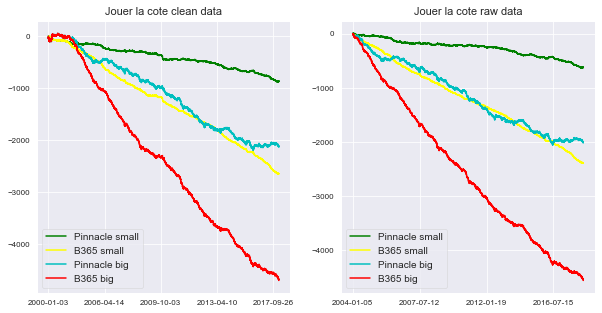

In [44]:
## Insérez votre code ici
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)

t = ax1.set_title("Jouer la cote clean data", fontsize = 11)

ax1.plot(df["Date"], df["PnLP_small"],"g", label = "Pinnacle small")
ax1.plot(df["Date"], df["PnLB_small"],"yellow", label = "B365 small")
ax1.plot(df["Date"], df["PnLP_big"],"c", label = "Pinnacle big")
ax1.plot(df["Date"], df["PnLB_big"],"red", label = "B365 big")

locs_x, labels_x = plt.xticks()
locs_y, labels_y = plt.yticks()
loc_x_new = np.arange(locs_x[0], locs_x[-1], step = 1000)
plt.xticks(loc_x_new)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

ax2 = fig.add_subplot(122)

t = ax2.set_title("Jouer la cote raw data", fontsize = 11)

ax2.plot(df_verif["Date"], df_verif["PnLP_small"],"g", label = "Pinnacle small")
ax2.plot(df_verif["Date"], df_verif["PnLB_small"],"yellow", label = "B365 small")
ax2.plot(df_verif["Date"], df_verif["PnLP_big"],"c", label = "Pinnacle big")
ax2.plot(df_verif["Date"], df_verif["PnLB_big"],"red", label = "B365 big")

locs_x, labels_x = plt.xticks()
locs_y, labels_y = plt.yticks()
loc_x_new = np.arange(locs_x[0], locs_x[-1], step = 1000)
plt.xticks(loc_x_new)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

ax1.legend(loc = "lower left",  fontsize = 10);
ax2.legend(loc = "lower left", fontsize = 10);
#il faudra retravailler les dates

Les profils sont similaires on peut donc légitimement penser que les remplissages de cotes vides n'affectent pas la consistance global des données. On peut néanmoins se demander si le plat 2008-2009 chez B365 n'est pas un artefact du au fait que l'on joue en fait le classement elo. l'accident aux alentours de 2009 semble provenir aussi du retraitement de la cote. 

In [47]:
from scipy.stats import pearsonr
pearsonr(df['PSW'],df["B365W"])

(0.9754642705428228, 0.0)

In [48]:
from scipy.stats import pearsonr
pearsonr(df['PSL'],df["B365L"])

(0.8958159757041179, 0.0)

In [49]:
from scipy.stats import pearsonr
pearsonr(df['PSW'],1/df["proba_elo"])

(0.7538665642790896, 0.0)

In [50]:
from scipy.stats import pearsonr
pearsonr(df['B365W'],1/df["proba_elo"])

(0.7623714165354378, 0.0)

In [51]:
df[['PSW', "B365W", "PSL", "B365L", "proba_elo"]].corr()

,PSW,B365W,PSL,B365L,proba_elo
PSW,1.000000,0.975464,-0.285524,-0.349092,-0.645579
B365W,0.975464,1.000000,-0.308790,-0.380120,-0.694919
PSL,-0.285524,-0.308790,1.000000,0.895816,0.514963
B365L,-0.349092,-0.380120,0.895816,1.000000,0.604092
proba_elo,-0.645579,-0.694919,0.514963,0.604092,1.000000


les cotes et la proba elo sont assez bien corréllées ce qui est plutôt logique et rassurant

il peut être intéréssant de calculer le nombre de joueur total et le nombre de match par joueur en base

In [52]:
#liste de tous les winners et losers
x = pd.concat([df.Winner, df.Loser], axis = 0)

In [53]:
print("il y", len(np.unique(x)), "joueurs présents dans la base")

il y 1381 joueurs présents dans la base


In [54]:
x.value_counts().describe()

count    1381.000000
mean       63.874004
std       137.172371
min         1.000000
25%         2.000000
50%         5.000000
75%        48.000000
max      1148.000000
dtype: float64

Il y a 50% des joueurs de la base qui apparaisent entre 1 et 6 fois

Il y a 50% des joueurs de la base qui apparaisent entre 1 et 6 fois,

cela pourra peut etre poser problème pour la consistance des prédictions.

In [29]:

df.to_csv("atp_data_clean.csv")